## 风格转换 

神经风格是深度学习领域一个很有趣的技术，它可以改变图片的风格，如下图所示，根据一张内容图片和一张风格图片，生成一个新图片，这张图片结合了第一张图像的内容和第二张图像的风格。

<img src="images/louvre_generated.png" style="width:750px;height:250px;">

In [1]:
# 导入必需的库

import os
import numpy as np
import tensorflow as tf
# load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import PIL.Image
import time
import functools

In [3]:
# 工具函数：从给定的地址加载图片
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img  = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [4]:
# 工具函数：将图片显示出来
def img_show(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

我们使用 Google 网站上的两张图片演示风格转换：

- content_path 内容图片的地址
- style_path 风格图片的地址

In [5]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

content_path: /home/edward/.keras/datasets/YellowLabradorLooking_new.jpg
style_path: /home/edward/.keras/datasets/YellowLabradorLooking_new.jpg


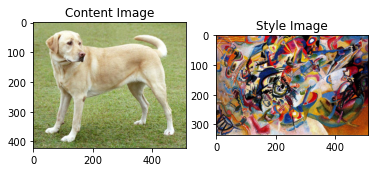

In [11]:
# 打印图片的路径
print('content_path:', content_path)
print('style_path:', content_path)

# 加载并显示图片
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
img_show(content_image, 'Content Image')

plt.subplot(1, 2, 2)
img_show(style_image, 'Style Image')

In [12]:
# 工具函数：将 tensor 转换为图片，并显示出来
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

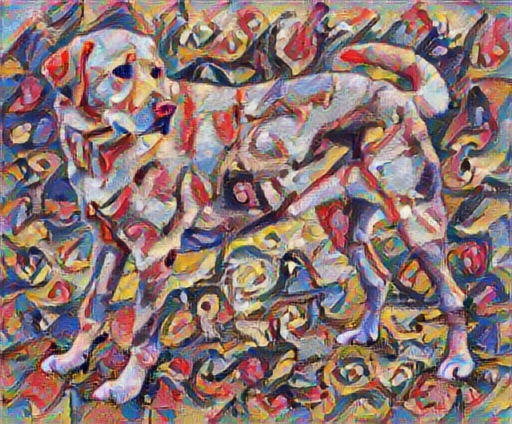

In [14]:
# 使用 tensorflow-hub 现成的模型来测试
import tensorflow_hub as hub
hub_model = hub.load('https://hub.tensorflow.google.cn/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

### 手动实现风格转换

我们使用已经训练好的 VGG-19 模型，这个模型已经在巨大的数据库上训练过了，它前面的神经网络层已经学会了识别很多低层次的特性，后面的神经网络层则能够识别很多高级复杂的特性。

下面的代码创建了一个 VGG-19 模型，并将在 imagenet 上训练好的参数值赋给它。

In [16]:
# include_top=False 表示不需要最后一层
# 我们只用 VGG-19 来做风格转换，不需要最后一层，最后一层是识别图片的
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# 打印每层的名字
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


我们知道：

- 前面的神经网络层会学习识别低层次的特性，比如边缘和纹理等
- 后面的神经网络层会学会高级复杂的特性，例如人脸和车

风格转换产生的图片既要有内容图片的内容，又要有风格图片的风格

我们使用内容图片的 VGG 的 block5_conv2 层来生成最终图像的内容

同时用风格图片的 VGG 的 block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1 来生成最终图片的风格

In [17]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1', 
                 'block2_conv1',
                 'block3_conv1',
                 'block4_conv1',
                 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [23]:
# 创建一个自定义的模型
# 在输入 vgg.input 后（也就是一张图片后），这个函数会返回上面定义的那些网络层的激活值
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

通过上面的函数，我们可以获取到代表内容和风格的网络层的激活值了。

我们需要先将激活值转换成风格矩阵，然后通过对比风格矩阵来判断两张图片的风格是否相同。

In [19]:
# 将激活值矩阵转换成风格矩阵 
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

我们使用 SubClassing 的方式定义一个类，整合上面的工具函数，输入一张图片后，这个类会返回这个图片的内容激活值矩阵以及风格矩阵。

In [26]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # Expects float input in [0, 1]
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name: value
                      for style_name, value 
                      in zip(self.style_layers, style_outputs)}
        
        return {
            'content': content_dict,
            'style': style_dict
        }


In [27]:
extractor = StyleContentModel(style_layers, content_layers)

In [29]:
# 获取风格图片的风格矩阵
style_targets = extractor(style_image)['style']

# 获取内容图片的内容激活值矩阵
content_targets = extractor(content_image)['content']

In [31]:
# 复制内容图片到 image
image = tf.Variable(content_image)

# 后面会不断根据 content_image 和 style_image 来改变 image
# 使 image 的风格越来越像 style_image

In [34]:
# 工具函数：用来修建图片的数值
# 输入一个张量，把张量中的每一个元素的值都压缩在 min 和 max 之间
# 小于 min 的让它等于 min，大于 max 的元素的值等于 max
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [35]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [37]:
# 控制风格化程度
style_weight=1e-2

# 控制内容保留的程度
content_weight=1e4

In [38]:
# 比较最终图片 image 与内容图片 content_image, 风格图片 style_image 的差别
# 即损失函数，差别越大损失越大
# 当 image 的内容越来越像 content_image，风格越来越像 style_image，那么损失就越来越小
def style_content_loss(outputs):
    # image 当前的风格矩阵
    style_outputs = outputs['style']

    # image 当前的内容激活值矩阵
    content_outputs = outputs['content']

    # 计算风格损失
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # 计算内容损失
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

In [41]:
# 定义完整的训练
@tf.function()
def train_step(image):
    # tape 会记录下前向传播的每一个步骤，后面自动进行反向传播
    with tf.GradientTape() as tape:
        # 获取当前 image 的内容激活值矩阵和风格矩阵
        outputs = extractor(image)

        # 计算损失
        loss = style_content_loss(outputs)

        # 获取 image 相对于 loss 的梯度
        # image 相当于 w, b 参数一样
        grad = tape.gradient(loss, image)

        # 使用梯度来改变 image
        opt.apply_gradients([(grad, image)])

        image.assign(clip_0_1(image))


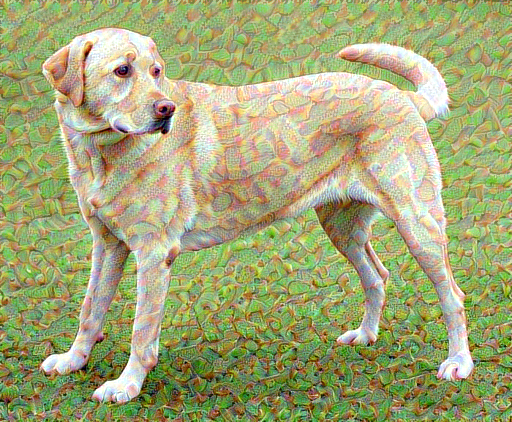

In [43]:
# 只训练 3 步简单测试
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

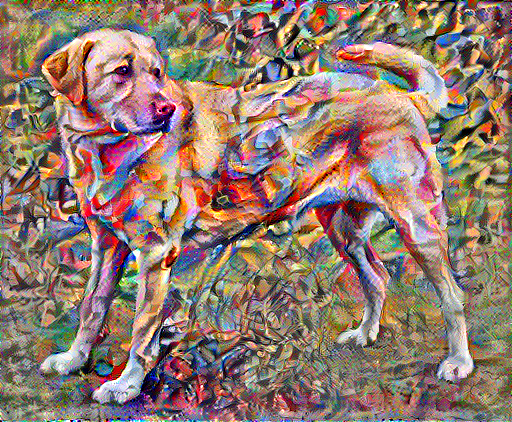

Train step: 1000
Total time: 205.1s


In [45]:
# 训练多次

import time
start = time.time()

epochs = 10
steps_per_epochs = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epochs):
        step += 1
        train_step(image)
        print('.', end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print('Train step: {}'.format(step))

end = time.time()
print('Total time: {:.1f}s'.format(end-start))